# 論文の再現性を確認 by めろ
To confirm the reproducibility of TOYOTA's paper by mero

[元の論文 Inoue, D., Okada, A., Matsumori, T. et al. Traffic signal optimization on a square lattice with quantum annealing. Sci Rep 11, 3303 (2021)](https://www.nature.com/articles/s41598-021-82740-0)

## assumptions

consider a squared map with $L\times L$ intersections, $\sigma_i$ represents $i$th intersection's traffic signal (north-south=1, west-east=-1)

number of vehicles from $i$th intersection to $i$th is
$$q_{ij}(t) = q_{ij}(t-1) + \frac{s_{ij}}{2} (-\sigma_i + \alpha \sigma_j)$$
flow bias is
$$x(t) = x(t-1) + (-I + \frac{\alpha}{4}A) \sigma(t-1)$$

## cost function (Ising model)

the cost function (Ising model) is defined as 
$$H(\sigma(t)) = x(t+1)^T x(t+1) + \eta(\sigma(t)-\sigma(t-1))^T(\sigma(t)-\sigma(t-1))$$

the cost function can be rearranged as
$$H(\sigma(t)) = \sigma(t)^T J \sigma(t) + h \sigma(t) + c(t)$$
where
$$J = (-I + \frac{\alpha}{4}A)^T(-I + \frac{\alpha}{4}A) + \eta I$$
$$h = 2x(t)^T (-I + \frac{\alpha}{4}A) - 2 \eta \sigma(t-1)^T$$

initial conditions
- $x(t=0)$ is generated as random numbers in uniform distribution within the range [-5.0, 5.0]
- $\sigma(t=0)$ is generated as random numbers either +1 or -1

dimsions confirmation
- signal vector $\sigma(t) = L^2 \times 1$
- flow bias $x(t) = L^2 \times 1$
- identity matrix $I = L^2 \times L^2$
- periodic lattice matrix $A = L^2 \times L^2$
- $J = L^2 \times L^2$
- $h = 1 \times L^2$

## implementations

### matrix generator

In [1]:
import numpy as np

def A_maker(L):
    A = np.zeros(L**4).reshape(L**2, L**2)
    
    for i in range(L):
        for j in range(L):
            """
            # every intersection has four neighborhoods
            """            
            four_dirc = []
            four_dirc.append( (i - 1) * L + j ) # north
            four_dirc.append( (i + 1) * L + j ) # south
            four_dirc.append( i * L + (j - 1) ) # west
            four_dirc.append( i * L + (j + 1) ) # east
            
            for neighbor in four_dirc:
                """
                # but does not count the neighbor who is out of the lattice range
                """
                if neighbor>=0 and neighbor<L**2:
                    A[i*L+j][neighbor] = 1
    
    return A

### params

In [2]:
# hyper-parameters
## in the original paper, L = 50, eta = 1.0, alpha = 0.8
## Figure.2
L = 50           # map size LxL
eta = 1.0        # weight
alpha = 0.8      # see print below
a = round((alpha+1)/2,2)
print(f'{a*100}% cars go straight, {100-a*100}% cars turn left/right')

theta = 3.0 # local control threshold

90.0% cars go straight, 10.0% cars turn left/right


In [3]:
# const matrix
import numpy as np
I = np.identity(L**2)
A = A_maker(L = L)           

In [4]:
# J is also constant
J = np.dot((- I + alpha/4*A).T, (- I + alpha/4*A)) + eta*I
Jdict = {}
for i in range(J.shape[0]):
    for j in range(i):
        Jdict[(i,j)] = J[i][j] * 2     

### energy calculation

In [5]:
def energy_calc(x, sigma, sigma_pre, eta):
    sigma_diff = sigma - sigma_pre
    energy_tmp = np.dot(x.T, x) + eta * np.dot(sigma_diff.T, sigma_diff)
    
    # energy is np.narray 1x1 dim
    ## return only float variable
    return energy_tmp[0][0]

## local control

In [6]:
# flow bias
x_local = np.random.uniform(low=-5.0, high=5.0, size=L**2).reshape(L**2, 1)

import random
sigma_list = [-1, 1]

# comparison, sigma for local control
sigma_local = random.choices(sigma_list, k = L**2)
sigma_local = np.reshape(sigma_local, (L**2, 1))

energy_local = []

In [7]:
for t in range(50):
    """
    # update local control
    """
    x_local += np.dot((- I + alpha/4*A), sigma_local)
    sigma_local_pre = sigma_local
    
    for i in range(L**2):
        if x_local[i][0] >= theta:
            sigma_local[i][0] = 1
        elif x_local[i][0] <= -theta:
            sigma_local[i][0] = -1
            
    energy_local_tmp = energy_calc(x_local, sigma_local, sigma_local_pre, eta)
    energy_local.append(energy_local_tmp)

    """
    energy records
    """
    print(f'{t}: energy_local = {energy_local_tmp}')

0: energy_local = 24387.88059868222
1: energy_local = 18174.924532810786
2: energy_local = 13994.591527157436
3: energy_local = 11546.32764313949
4: energy_local = 10326.685920938193
5: energy_local = 10412.98535774681
6: energy_local = 10917.012078006364
7: energy_local = 11138.278359359065
8: energy_local = 11017.244174266812
9: energy_local = 10942.772056465166
10: energy_local = 11059.853655111341
11: energy_local = 11637.272282401655
12: energy_local = 11673.446497433317
13: energy_local = 11322.070356671984
14: energy_local = 11458.052762365749
15: energy_local = 11518.235111041531
16: energy_local = 11869.784004846364
17: energy_local = 11675.680150643815
18: energy_local = 11322.839121806148
19: energy_local = 10990.240063597634
20: energy_local = 10734.391497454155
21: energy_local = 10783.371250901702
22: energy_local = 11231.12142863337
23: energy_local = 11615.570077196178
24: energy_local = 11541.656021070608
25: energy_local = 11600.587281990343
26: energy_local = 11680.4

## QA iterations

In [8]:
import openjij as oj
sampler = oj.SASampler(num_reads = 5)

In [9]:
# flow bias
x_qa = np.random.uniform(low=-5.0, high=5.0, size=L**2).reshape(L**2, 1)

# sigma for QA analysis
sigma_qa = random.choices(sigma_list, k = L**2)
sigma_qa = np.reshape(sigma_qa, (L**2, 1))

In [10]:
energy_qa = []

## t = 100, in paper Figure.2
for t in range(50):
    """
    # update QA
    """
    x_qa += np.dot((- I + alpha/4*A), sigma_qa)
    sigma_qa_pre = sigma_qa
    
    h = 2*np.dot(x_qa.T, (- I + alpha/4*A)) - 2*np.dot(eta, sigma_qa.T)
    h = h.reshape(L**2)
    h_dict = {}
    for i in range(len(h)):
        h_dict[i] = h[i]
    
    # QA ising model
    sigma_qa_t = sampler.sample_ising(h_dict, Jdict) 
    tmp = sigma_qa_t.first.sample
    sigma_qa = np.reshape(list(tmp.values()), (L**2, 1))
    
    energy_qa_tmp = energy_calc(x_qa, sigma_qa, sigma_qa_pre, eta)
    energy_qa.append(energy_qa_tmp)
    ## energy.append(sigma_qa_t.first.energy)
    
    """
    energy records
    """
    print(f'{t}: energy_qa = {energy_qa_tmp}')    

0: energy_qa = 29323.262698908457
1: energy_qa = 14009.127484542965
2: energy_qa = 7976.891021258148
3: energy_qa = 5059.332083138044
4: energy_qa = 3727.031886690778
5: energy_qa = 3429.2530948332815
6: energy_qa = 3311.388800501286
7: energy_qa = 3391.4472371423367
8: energy_qa = 3522.2827783415405
9: energy_qa = 3952.391671729825
10: energy_qa = 4144.905224726543
11: energy_qa = 4632.421998537977
12: energy_qa = 4989.5159356258755
13: energy_qa = 4971.929622896523
14: energy_qa = 5204.521368581348
15: energy_qa = 5119.581508606787
16: energy_qa = 5024.437208555623
17: energy_qa = 5239.750438750489
18: energy_qa = 5326.629375348153
19: energy_qa = 5255.150100893204
20: energy_qa = 5075.538488628854
21: energy_qa = 4956.101499035119
22: energy_qa = 5112.433032309119
23: energy_qa = 4972.812319782388
24: energy_qa = 5102.683340127385
25: energy_qa = 5148.876873976258
26: energy_qa = 4954.194246890167
27: energy_qa = 5085.082801245601
28: energy_qa = 4945.887161558981
29: energy_qa = 50

## result plot

### traffic intersection signals

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m6swv488 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


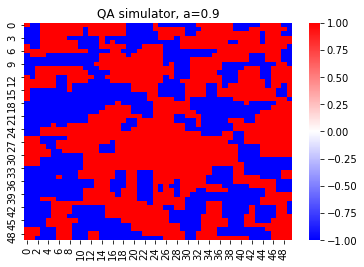

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_qa = sigma_qa.reshape(L, L)
sns.heatmap(heatmap_qa, cmap = 'bwr')
plt.title(f'QA simulator, a={a}')
plt.savefig(f'figs/QA simulator, a={a}.png')

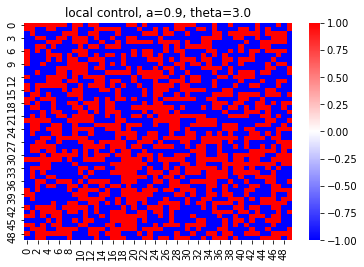

In [12]:
heatmap_local = sigma_local.reshape(L, L)
sns.heatmap(heatmap_local, cmap = 'bwr')
plt.title(f'local control, a={a}, theta={theta}')
plt.savefig(f'figs/local control, a={a}, theta={theta}.png')

### energy

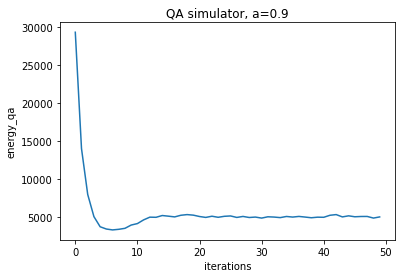

In [13]:
plt.plot(energy_qa)
plt.xlabel('iterations')
plt.ylabel('energy_qa')
plt.title(f'QA simulator, a={a}')
plt.savefig(f'figs/QA simulator energy, a={a}.png')

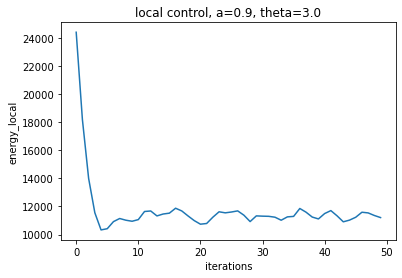

In [14]:
plt.plot(energy_local)
plt.xlabel('iterations')
plt.ylabel('energy_local')
plt.title(f'local control, a={a}, theta={theta}')
plt.savefig(f'figs/local control energy, a={a}, theta={theta}.png')